# 데이터 불러오기

In [5]:
#빅카인즈 환경카테고리 뉴스(2023년 1월 ~ 6월)
import pandas as pd
txt_df = pd.read_excel('NewsResult_20230101-20230630.xlsx')
txt_df['제목']

C:\Users\kwater\AppData\Local\Programs\Python\Python39\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


0                 물놀이 잘 즐겼는데 복통 구토 계곡물 담가놓은 수박의 배신
1                          경상남도, ‘국가 녹조대응센터 건립’ 요청
2                             내일부터 전주지역 쓰레기 권역별 수거
3                     “제2공항 쟁점, 기본계획 고시 전 공동 검증해야”
4                   낙동강 하굿둑 전 수문 개방 오늘 밤 20~70mm 비
                           ...                    
15083                 “가정 내 흡연자 있으면 초미세먼지 등 농도 높아”
15084             "가정 내 흡연자 있으면 초미세먼지 이산화탄소 농도 높다"
15085              [주말 날씨] 새해 첫 해돋이 볼 수 있어 미세먼지 주의
15086    2023년 새해엔 ‘환경 기념일’ 기억하세요 매월 작은 실천이 지구를 지켜
15087                            [신년인사] 최교진 세종시교육감
Name: 제목, Length: 15088, dtype: object

# 데이터 전처리

In [53]:
#한글, 영어, 숫자 제외한 특수기호 등 제거
import re
sentences = txt_df['제목'].tolist()
sentences = [re.sub('[^가-힗A-Za-z0-9]', ' ', str(s)) for s in sentences]
sentences[:10]

['물놀이 잘 즐겼는데 복통 구토 계곡물 담가놓은 수박의 배신',
 '경상남도   국가 녹조대응센터 건립  요청',
 '내일부터 전주지역 쓰레기 권역별 수거',
 ' 제2공항 쟁점  기본계획 고시 전 공동 검증해야 ',
 '낙동강 하굿둑 전 수문 개방 오늘 밤 20 70mm 비',
 ' 날씨  내일부터 무더위 기승 서울  춘천 34도',
 '경상남도   국가 녹조대응센터 건립  요청',
 '낙동강 하굿둑 전 수문 개방 오늘 밤 20 70mm 비',
 '속리산국립공원사무소 이상철 신임 소장 부임',
 ' 수십년 감축 노력  프레온가스 빼곤 매년 온실가스 짙어지는 한반도']

# 명사 추출기 학습

cohesion_forward(응집확률): 
- 특정 문자열이 얼마나 같이(응집하여) 등장하는 지 판단하는 척도
- 각 문자열을 문자 단위로 분리한 뒤 왼쪽부터 순서대로 문자를 추가하면서 각 문자열이 주어졌을 때 그 다음 문자가 나올 확률을 계산하여 누적곱을 한 값

branching_entropy(브랜칭 엔트로피):
- 주어진 문자열에서 다음 문자가 얼마나 등장할 수 있는지를 판단하는 척도
- 엔트로피값은 불확실성의 정도로 예측할 수 있는 그 다음의 글자를 예측할 수 있는 가능성이 높아질 수록 값은 커짐

In [7]:
from soynlp.word import WordExtractor

word_extractor = WordExtractor(min_frequency=10,
    min_cohesion_forward=0.05,
    min_right_branching_entropy=0.0
)
word_extractor.train(sentences)
words = word_extractor.extract()

training was done. used memory 0.291 Gbory 0.250 Gb
all cohesion probabilities was computed. # words = 4684
all branching entropies was computed # words = 18255
all accessor variety was computed # words = 18255


# 단어 구분

In [15]:
#WordExtractor 결과 점수를 이용한 단어 구분
from soynlp.tokenizer import MaxScoreTokenizer

scores = dict()
for word, score in words.items():
    scores[word] = score.cohesion_forward * math.exp(score.right_branching_entropy)

tokenizer = MaxScoreTokenizer(scores=scores)
sentences_token = [tokenizer.tokenize(str(sent)) for sent in sentences]
sentences_token_rs = list()

#불용어 설정
stopwords=[]

for sent in sentences_token:
    new_sent = [word for word in sent if (word not in stopwords) and (len(word)>1)]
    sentences_token_rs.append(new_sent)
    
sentences_token_conc = [" ".join(str(word) for word in sent) for sent in sentences_token_rs]

# 단어 빈도수 추출

In [20]:
#문서별 단어 출현 기반 벡터화를 통한 단어 빈도수 추출
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(binary = True, lowercase=False, token_pattern='(?u)\\b\\w+\\b')
X = vec.fit_transform(sentences_token_conc)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
colSum = df.sum(axis=0).sort_values(ascending=False)

#단어 빈도수 딕셔너리화
dict_word = dict(zip(colSum.index,colSum.values))
dict_word

환경      2365
미세먼지    1723
날씨      1073
쓰레기      808
환경부      675
        ... 
양대혁        1
양덕원천       1
맡겨         1
기저막        1
서기원        1
Length: 18070, dtype: int64

# 워드클라우드 시각화

C:\Users\kwater\AppData\Local\Temp\ipykernel_26712\2786390713.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  heart_mask[np.where(heart_mask == np.array([0, 0, 0, 0]))] = 255


(-0.5, 1279.5, 719.5, -0.5)

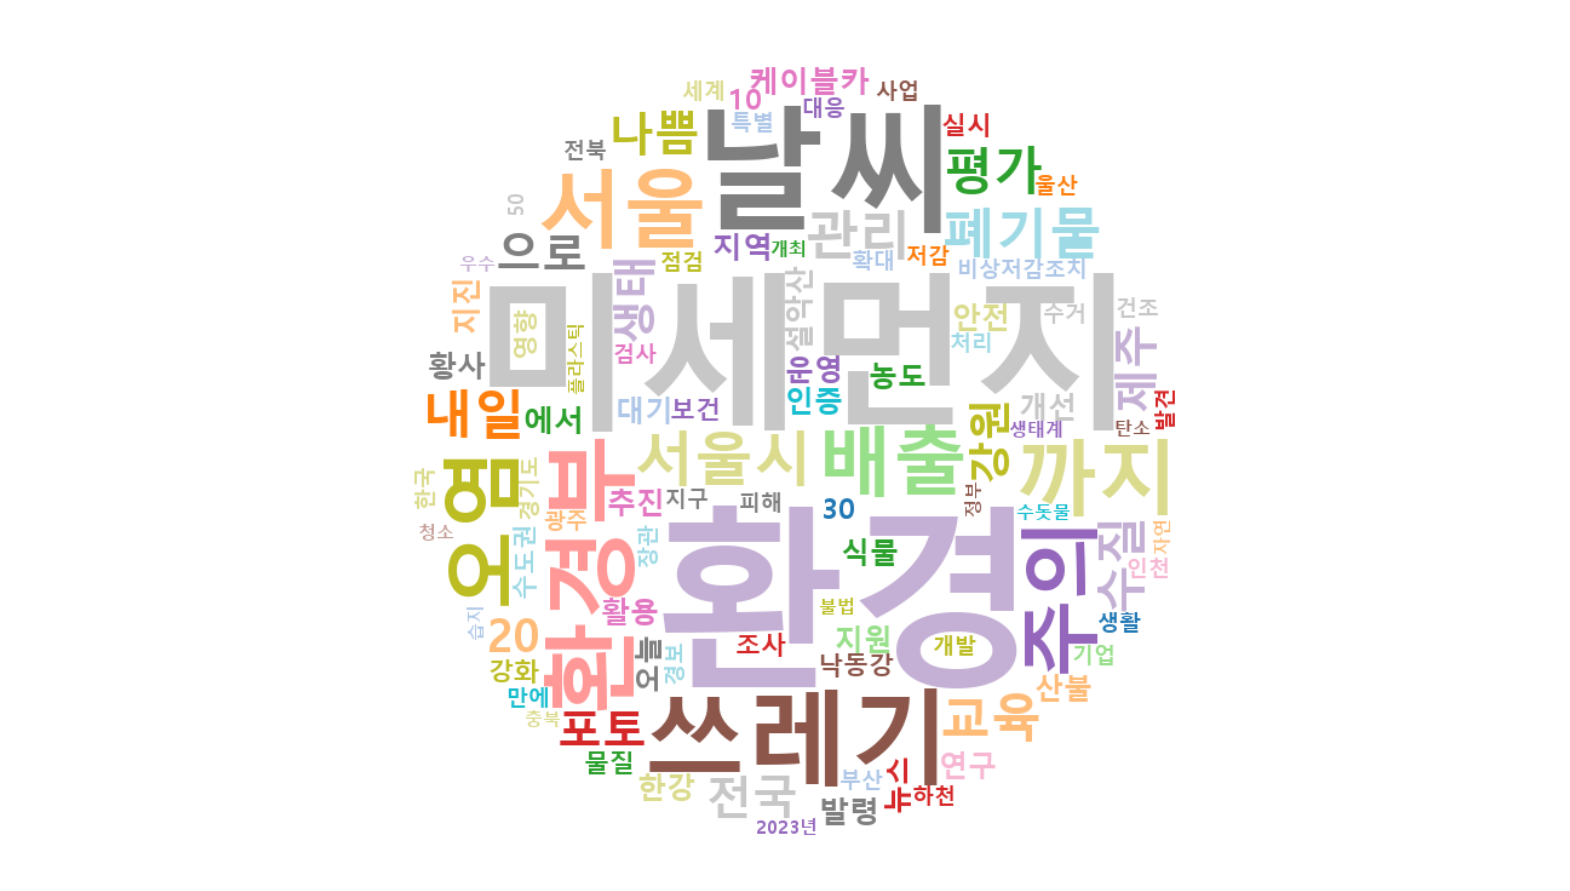

In [48]:
from PIL import Image
from wordcloud import WordCloud,STOPWORDS, get_single_color_func
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


maskfname = "circle.png"
heart_mask = np.array(Image.open(maskfname))
heart_mask[np.where(heart_mask == np.array([0, 0, 0, 0]))] = 255


#워드클라우드 상세 설정
wordcloud = WordCloud(font_path="./font/malgunbd.ttf", background_color = "rgba(255, 255, 255, 0)",contour_width = 0, contour_color="black",
                      colormap = 'tab20', max_words=100, mask=heart_mask)


wordcloud.generate_from_frequencies(dict_word)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")